# Фильтрация изображений

## Загружаем и выводим тестовое изображение

In [2]:
import cv2
import numpy as np

In [3]:
img = cv2.imread('./lena.png')

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

Text(0.5,1,'Размер изображения: 512x512x3')

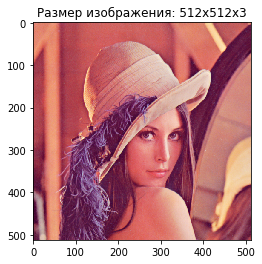

In [4]:
plt.imshow(img[...,::-1]) # b g r -> r g b
plt.title('Размер изображения: %dx%dx%d' % img.shape)

## Оператор Собеля

In [10]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [6]:
img.dtype

dtype('uint8')

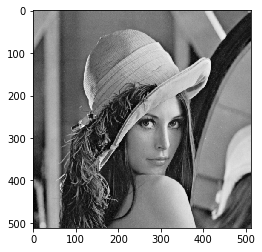

In [7]:
plt.imshow(img_gray, cmap='gray')

### Оператор собеля для вычисления X и Y составляющих градиента

In [8]:
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
    
sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]])

### Вычисляем градиенты по осям

In [9]:
grad_x = cv2.filter2D(img_gray, cv2.CV_32F, sobel_x)
grad_y = cv2.filter2D(img_gray, cv2.CV_32F, sobel_y)

In [10]:
grad_x_norm = np.abs(grad_x)/np.max(np.abs(grad_x))
grad_y_norm = np.abs(grad_y)/np.max(np.abs(grad_y))

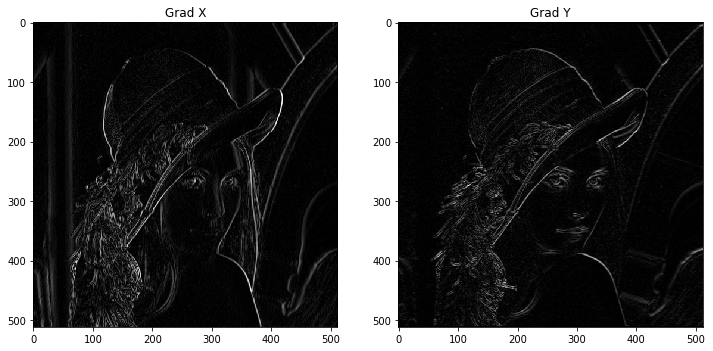

In [16]:
plt.figure(2, figsize=(12, 8))
plt.subplot(121)
plt.imshow(grad_x_norm, cmap='gray')
plt.title('Grad X')
plt.subplot(122)
plt.imshow(grad_y_norm, cmap='gray')
plt.title('Grad Y');

### Вычисляем суммарный градиент

In [17]:
grad = np.sqrt(grad_x ** 2 + grad_y ** 2)
theta = np.arctan2(grad_y, grad_x)

In [18]:
grad.shape

(512, 512)

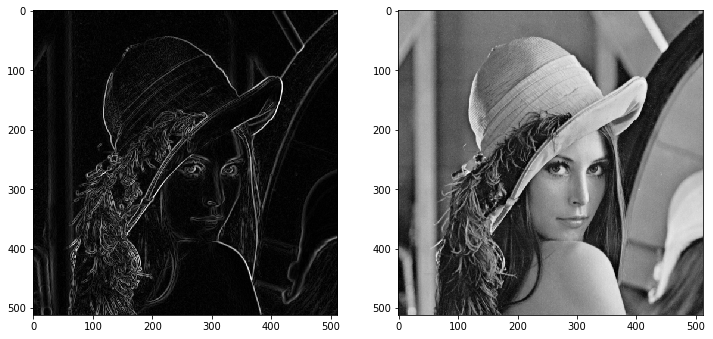

In [19]:
plt.figure(2, figsize=(12, 8))
plt.subplot(122)
plt.imshow(img_gray, cmap='gray')
plt.subplot(121)
plt.imshow(grad, cmap='gray')

## Функции создания ядер

Гауссиана:
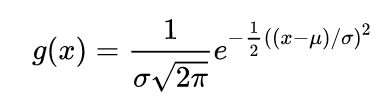

In [11]:
def gauss_kernel(ksize = 5, sigma = 2.5):
    """
    Возвращает гауссовское ядро размера ksize и дисперсией sigma
    ksize - размер ядра (int)
    sigma - дисперсия (ширина фильтра) (float)
    """
    
    # задаём координатную сетку
    ax = np.arange(-ksize // 2 + 1., ksize // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    
    # применяем функцию Гаусса
    e = np.float32((xx**2 + yy**2) / (2. * sigma**2))
    kernel = 1. / (sigma * np.sqrt(2. * np.pi)) * np.exp(-e)
    return kernel / np.sum(kernel) # нормируем (приводим сумму к 1)


def laplace_kernel(ksize = 5, sigma = 2.5):
    """
    Возвращает ядро Лапласа размера ksize и дисперсией sigma
    ksize - размер ядра (int)
    sigma - дисперсия (ширина фильтра) (float)
    """
    
    # задаём координатную сетку
    ax = np.arange(-ksize // 2 + 1., ksize // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    
    ## оператор Лапласа
    e = np.float32((xx**2 + yy**2) / (2. * sigma**2))
    kernel = 1. / (np.pi * sigma**4) * (1. - e) * np.exp(-e)
    return kernel / np.sum(kernel) # нормируем

kernels = {'gauss': gauss_kernel, 
           'laplace': laplace_kernel}

In [12]:
gauss_kernel(3)

array([[0.10518943, 0.11395035, 0.10518943],
       [0.11395035, 0.12344094, 0.11395035],
       [0.10518943, 0.11395035, 0.10518943]], dtype=float32)

## Визуализация ядер

\# pip install ipywidgets<br/>
\# jupyter nbextension enable --py widgetsnbextension

In [13]:
from mpl_toolkits.mplot3d import Axes3D

In [14]:
def show_kernel(kernel_type, ksize, sigma):
    kernel = kernels[kernel_type](ksize, sigma)
    r = np.arange(-ksize // 2 + 1., ksize // 2 + 1.)
    xx, yy = np.meshgrid(r, r)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, kernel, 
                    cmap=plt.cm.coolwarm,
                    linewidth=0, antialiased=True)
    plt.title('%s ksize=%s sigma=%.3f' % (kernel_type, ksize, sigma))
    return plt.show()

In [15]:
from ipywidgets import interact

In [16]:
interact(show_kernel, 
         kernel_type = kernels.keys(),
         ksize = (1, 20, 1),
         sigma = (1e-3, 10, 0.1));

interactive(children=(Dropdown(description='kernel_type', options=('gauss', 'laplace'), value='gauss'), IntSli…

## Фильтрация изображения

In [28]:
kernels

{'gauss': <function __main__.gauss_kernel(ksize=5, sigma=2.5)>,
 'laplace': <function __main__.laplace_kernel(ksize=5, sigma=2.5)>}

In [56]:
kernel = kernels['gauss'](3, 1)

In [57]:
kernel

array([[0.07511361, 0.12384141, 0.07511361],
       [0.12384141, 0.20417997, 0.12384141],
       [0.07511361, 0.12384141, 0.07511361]], dtype=float32)

In [58]:
img_filtered = cv2.filter2D(img, cv2.CV_32F, kernel)

In [59]:
abs_img_filtered = np.abs(img_filtered)

In [60]:
# нормировка
channel_max = abs_img_filtered.max(axis=(0, 1))
norm_img_filtered = abs_img_filtered / channel_max

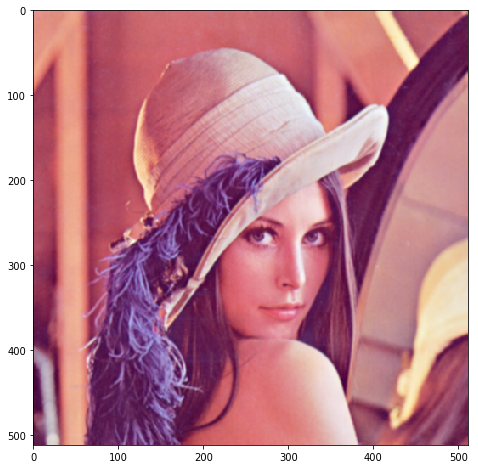

In [61]:
plt.figure(1, figsize=(8, 8))
plt.imshow(norm_img_filtered[..., ::-1])

### Функция для отображения картинки в зависимости от ядра

In [17]:
def filter_img(kernel_type, ksize = 5, sigma = 2.5):
    kernel = kernels[kernel_type](ksize, sigma)
    result = cv2.filter2D(img, cv2.CV_32F, kernel)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    img_abs = np.abs(result)
    img_norm = img_abs / np.max(img_abs, axis=(0, 1))
    ax.imshow(img_norm[...,::-1])
    plt.title('%s ksize=%s sigma=%.3f' % (kernel_type, ksize, sigma))
    return plt.show()

In [18]:
interact(filter_img, 
         kernel_type = kernels.keys(),
         ksize = (1, 20, 1),
         sigma = (1e-3, 10, 0.1));

interactive(children=(Dropdown(description='kernel_type', options=('gauss', 'laplace'), value='gauss'), IntSli…

In [3]:
def print_hello_world(size):
    print('hello world'[:size])

In [5]:
interact(print_hello_world, size=(0, 11, 1))

interactive(children=(IntSlider(value=5, description='size', max=11), Output()), _dom_classes=('widget-interac…

<function __main__.print_hello_world(size)>

## Задания

* Пользуясь примером, напишите и примените фильтр увеличения контрастности из лекции
* Придумайте свой филтьтр-матрицу (любого размера, не обязательно 3x3) и примените его к изображению (при необходимости, нормируйте)

In [4]:
mean_filter = np.ones(49)
mean_filter.reshape(7, 7)

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

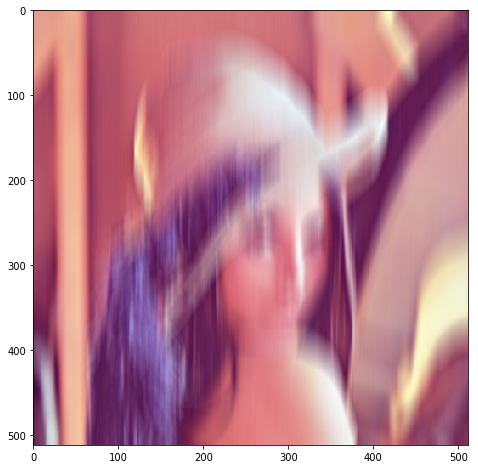

In [7]:
img_filtered = cv2.filter2D(img, cv2.CV_32F, mean_filter)
abs_img_filtered = np.abs(img_filtered)
# нормировка
channel_max = abs_img_filtered.max(axis=(0, 1))
norm_img_filtered = abs_img_filtered / channel_max
plt.figure(1, figsize=(8, 8))
plt.imshow(norm_img_filtered[..., ::-1])